In [1]:
# libraries
import pandas as pd
import re
from scipy.stats.mstats import trimmed_var
from EDA import make_plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from dash_app import run_simulation
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
df.head()

Product_Code  W0  W1  W2  W3  W4  W5  W6  W7  W8  ...  Normalized 42  \
0           P1  11  12  10   8  13  12  14  21   6  ...           0.06   
1           P2   7   6   3   2   7   1   6   3   3  ...           0.20   
2           P3   7  11   8   9  10   8   7  13  12  ...           0.27   
3           P4  12   8  13   5   9   6   9  13  13  ...           0.41   
4           P5   8   5  13  11   6   7   9  14   9  ...           0.27   

   Normalized 43  Normalized 44  Normalized 45  Normalized 46  Normalized 47  \
0           0.22           0.28           0.39           0.50           0.00   
1           0.40           0.50           0.10           0.10           0.40   
2           1.00           0.18           0.18           0.36           0.45   
3           0.47           0.06           0.12           0.24           0.35   
4           0.53           0.27           0.60           0.20           0.20   

   Normalized 48  Normalized 49  Normalized 50  Normalized 51  
0           0.22           0.17           0.11           0.39  
1           0.50           0.10           0.60           0.00  
2           1.00           0.45           0.45           0.36  
3           0.71           0.35           0.29           0.35  
4           0.13           0.53           0.33           0.40  

[5 rows x 107 columns]

In [3]:
def wrangle(filename):
    df = pd.read_csv(filename)
    #Dropping Normizalized Data
    col_to_drop = [i for i in df.columns if re.match(r'Normalized',i)]
    df.drop(columns=col_to_drop,inplace=True)
    #Dropping the product code
    df.drop(columns='Product_Code',inplace=True)
    return df

In [4]:
wrangled_df = wrangle('Sales_Transactions_Dataset_Weekly.csv')

In [5]:
wrangled_df

W0  W1  W2  W3  W4  W5  W6  W7  W8  W9  ...  W44  W45  W46  W47  W48  \
0    11  12  10   8  13  12  14  21   6  14  ...    8   10   12    3    7   
1     7   6   3   2   7   1   6   3   3   3  ...    5    1    1    4    5   
2     7  11   8   9  10   8   7  13  12   6  ...    5    5    7    8   14   
3    12   8  13   5   9   6   9  13  13  11  ...    3    4    6    8   14   
4     8   5  13  11   6   7   9  14   9   9  ...    7   12    6    6    5   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
806   0   0   1   0   0   2   1   0   0   1  ...    1    0    0    1    0   
807   0   1   0   0   1   2   2   6   0   1  ...    4    2    4    5    5   
808   1   0   0   0   1   1   2   1   1   0  ...    0    2    2    0    0   
809   0   0   0   1   0   0   0   0   1   0  ...    0    1    1    0    0   
810   0   1   0   0   0   0   0   0   0   0  ...    0    0    0    0    0   

     W49  W50  W51  MIN  MAX  
0      6    5   10    3   21  
1      1    6    0    0   10  
2      8    8    7    3   14  
3      8    7    8    2   19  
4     11    8    9    3   18  
..   ...  ...  ...  ...  ...  
806    0    2    0    0    3  
807    5    6    5    0    7  
808    0    4    3    0    4  
809    0    2    0    0    2  
810    0    0    1    0    3  

[811 rows x 54 columns]

In [6]:
make_plots(wrangled_df)

SELECT PLOT TO SHOW BELOW: 


interactive(children=(Dropdown(description='plot_type', index=1, options=('Scatter', 'Histogram & Boxplot'), v…

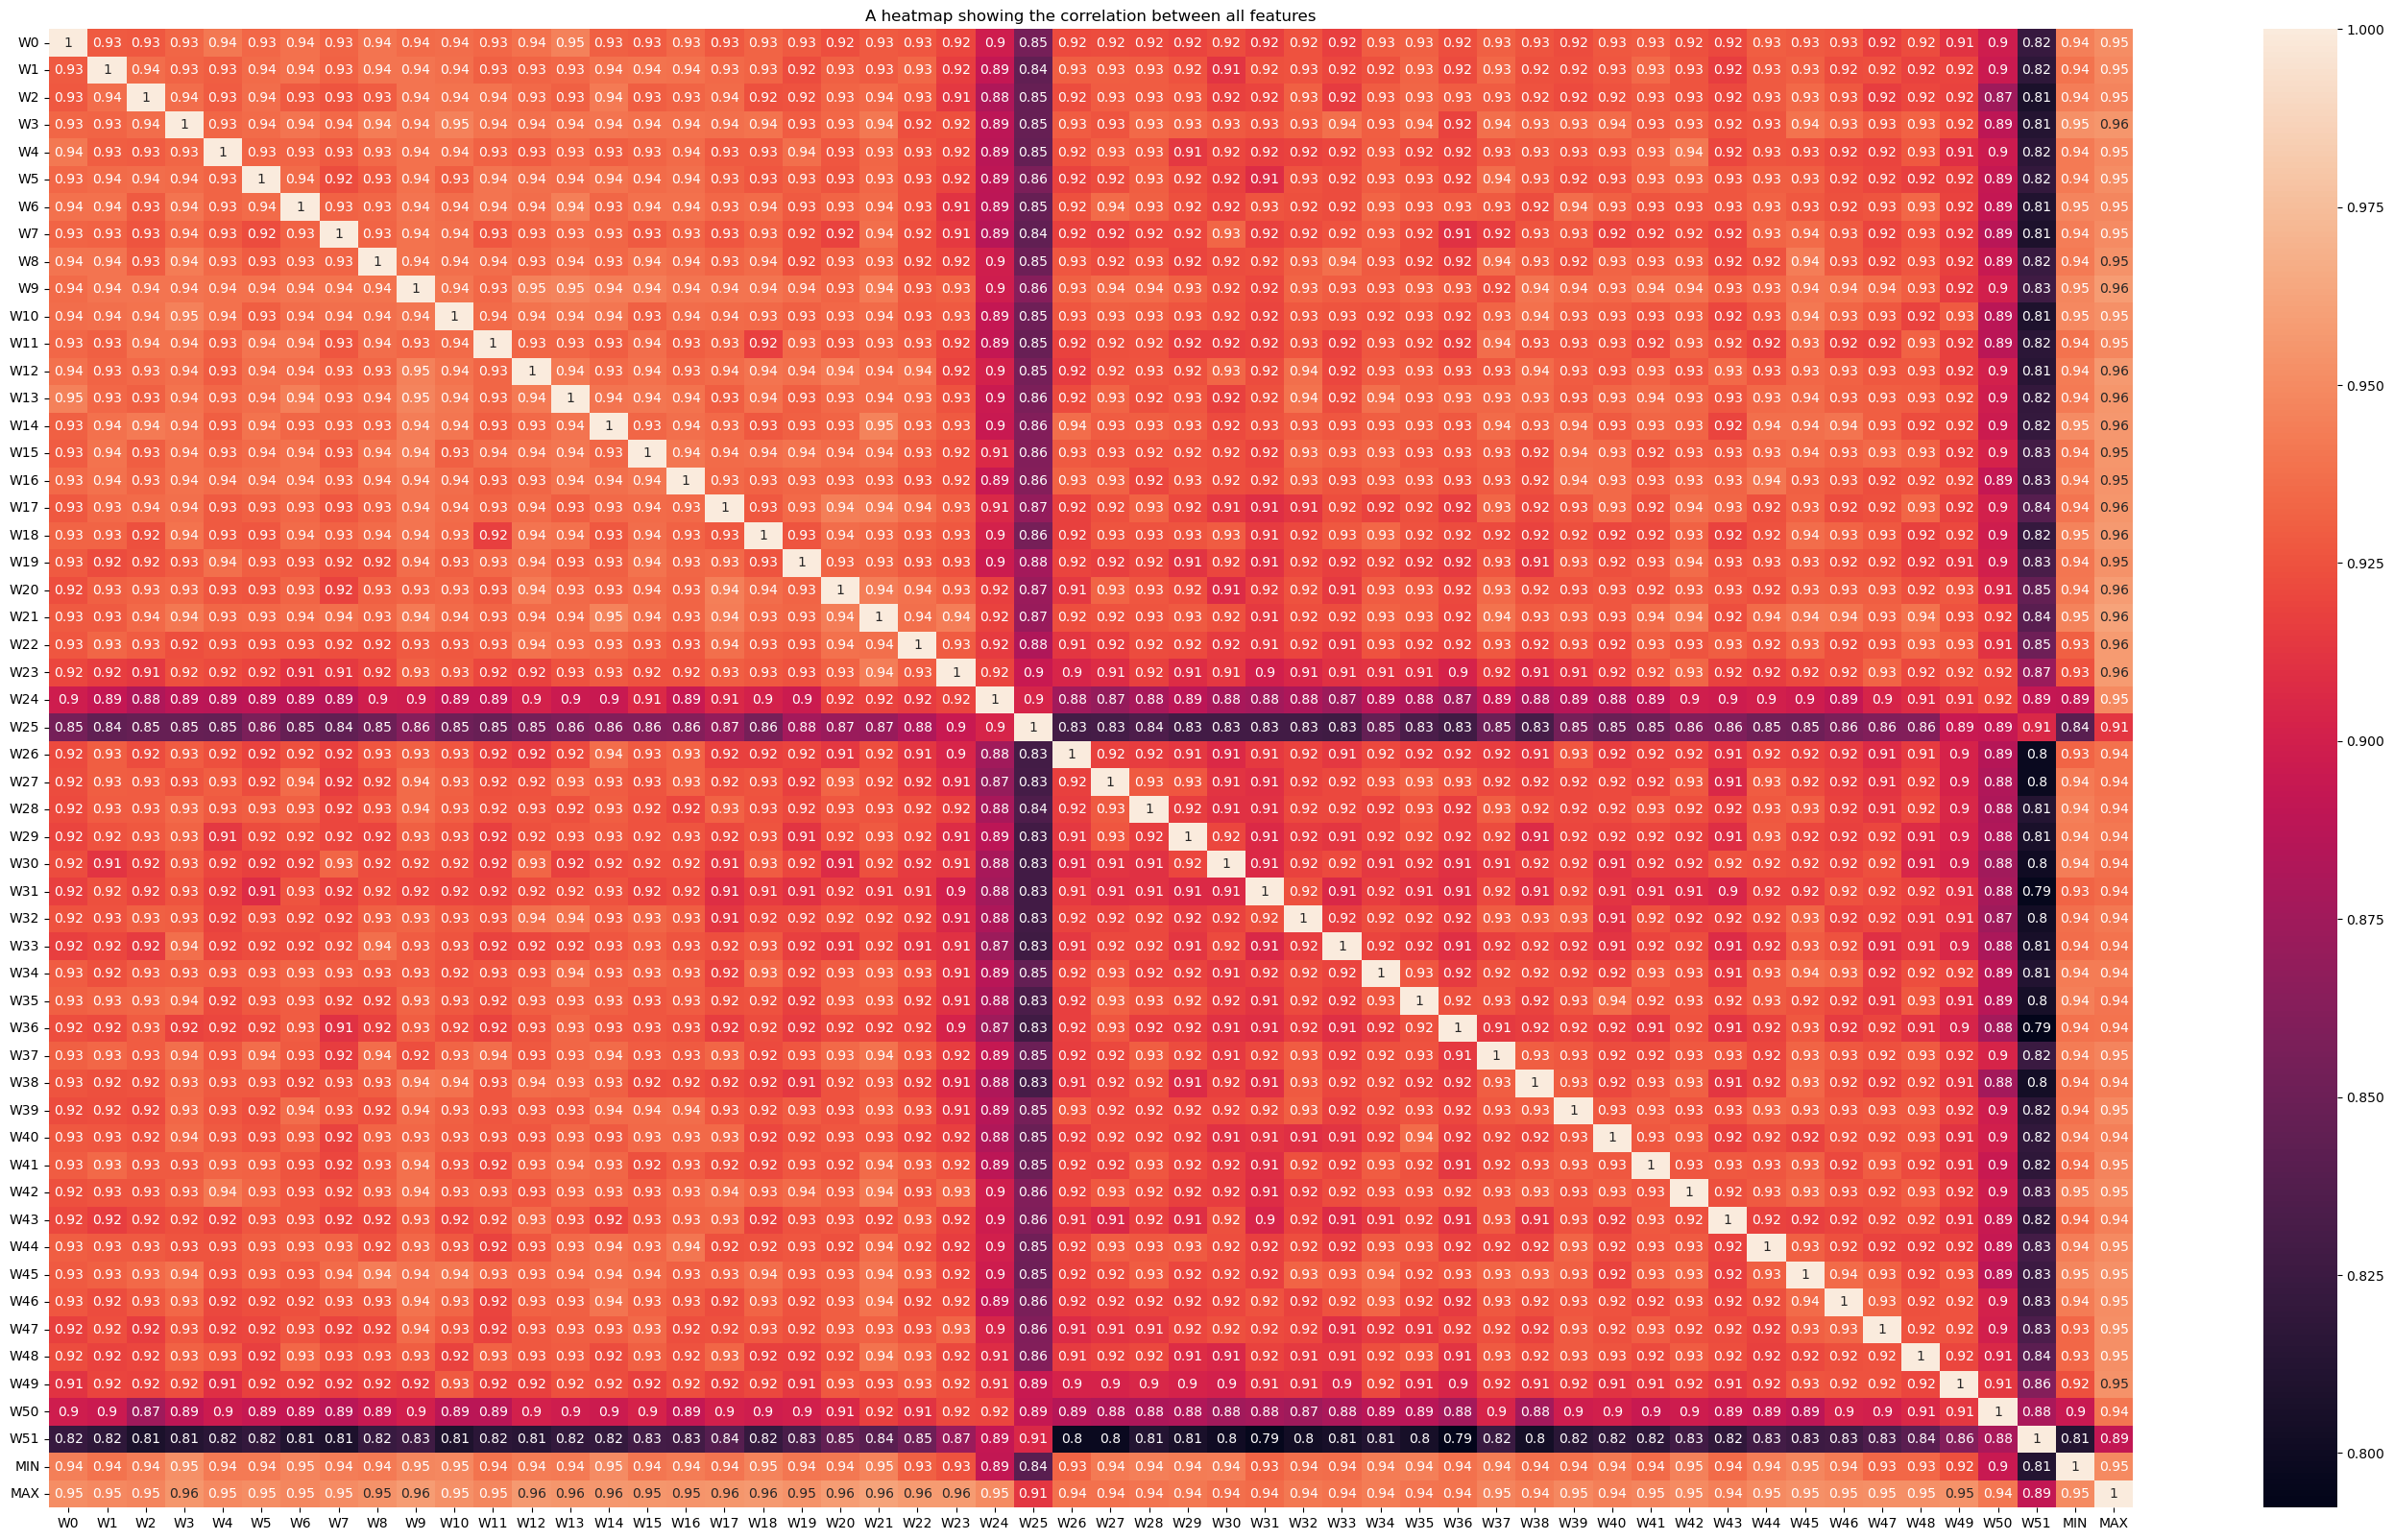

In [7]:
fig,ax = plt.subplots(figsize=(35,20))
corr = sns.heatmap(wrangled_df.corr(),ax=ax,annot=True)
plt.title('A heatmap showing the correlation between all features');

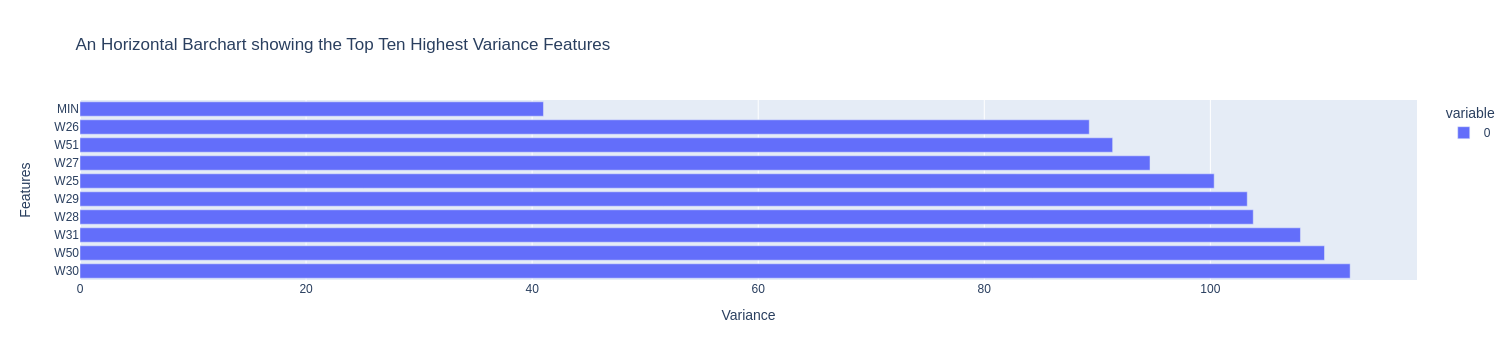

In [8]:
top_10_feature_var = wrangled_df.var().sort_values(ascending=False).tail(10)
fig = px.bar(top_10_feature_var,orientation='h',title='An Horizontal Barchart showing the Top Ten Highest Variance Features',
                labels={'index':'Features','value':'Variance'})
fig.show()

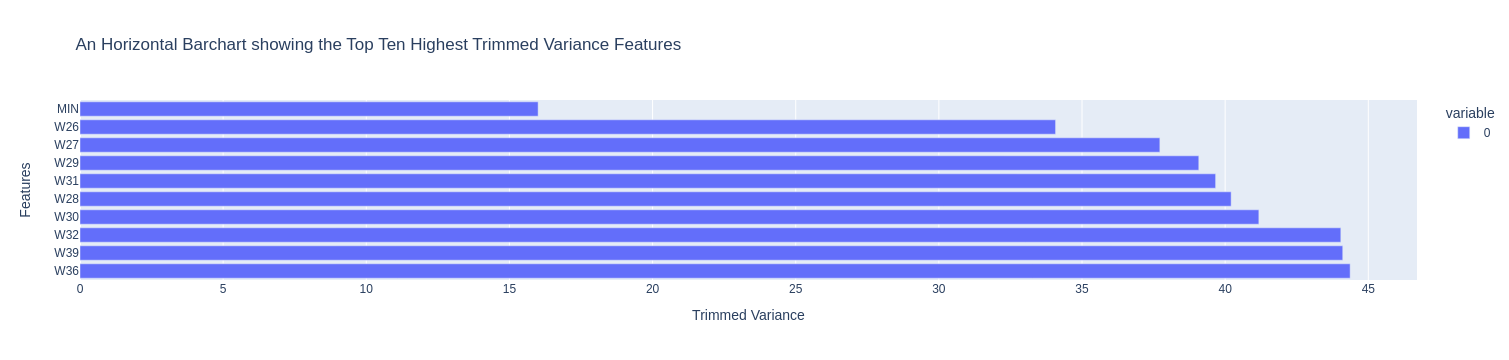

In [9]:
top_10_trimmed_feature_var = wrangled_df.apply(trimmed_var).sort_values(ascending=False).tail(10)
fig = px.bar(top_10_trimmed_feature_var,orientation='h',title='An Horizontal Barchart showing the Top Ten Highest Trimmed Variance Features',
                labels={'index':'Features','value':'Trimmed Variance'})
fig.show()

In [10]:
trimmed_feature = top_10_trimmed_feature_var.head(5).index
trimmed_feature

Index(['W36', 'W39', 'W32', 'W30', 'W28'], dtype='object')

In [11]:
X = wrangled_df[trimmed_feature]

In [12]:
ss_score = []
inertia = []
for k in range(2,13):
    model = make_pipeline(StandardScaler(),KMeans(n_clusters=k))
    model.fit(X)
    inertia.append(model.named_steps['kmeans'].inertia_)
    labels = model.named_steps['kmeans'].labels_
    ss_score.append(silhouette_score(X,labels))

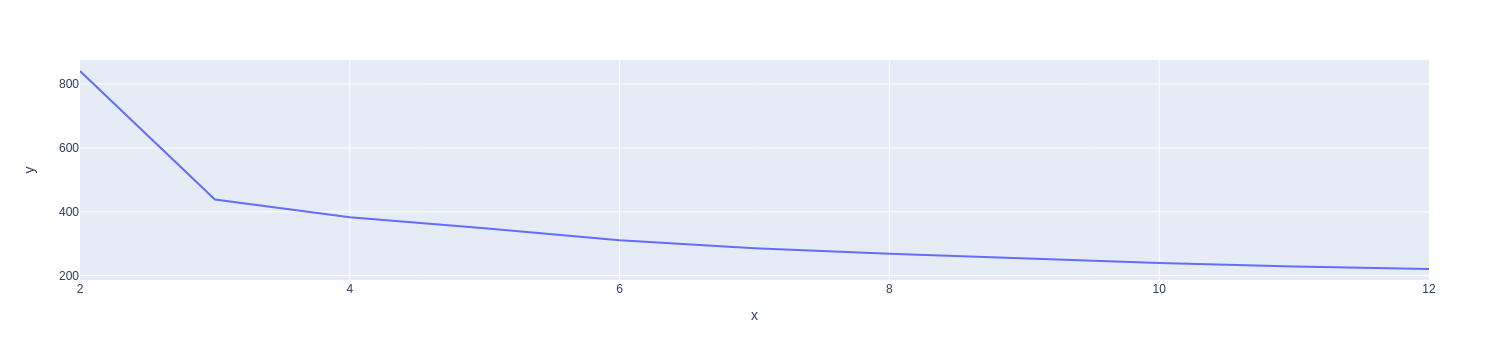

In [13]:
px.line(y=inertia,x=range(2,13))

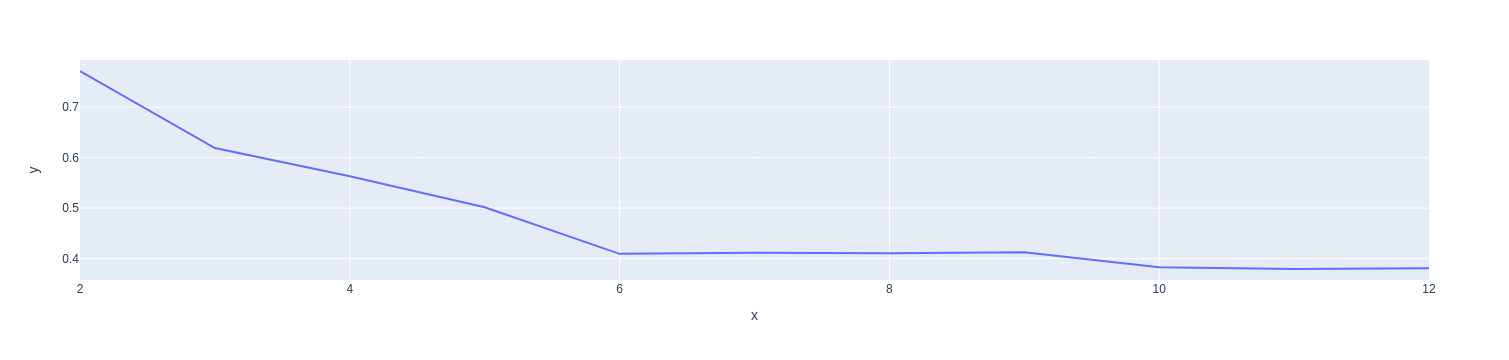

In [14]:
px.line(y=ss_score,x=range(2,13))

In [15]:
final_model = make_pipeline(StandardScaler(),KMeans(n_clusters=3))
final_model.fit(X)
labels = final_model.named_steps['kmeans'].labels_
X['label'] = labels

In [16]:
xgbm = X.groupby('label').mean()

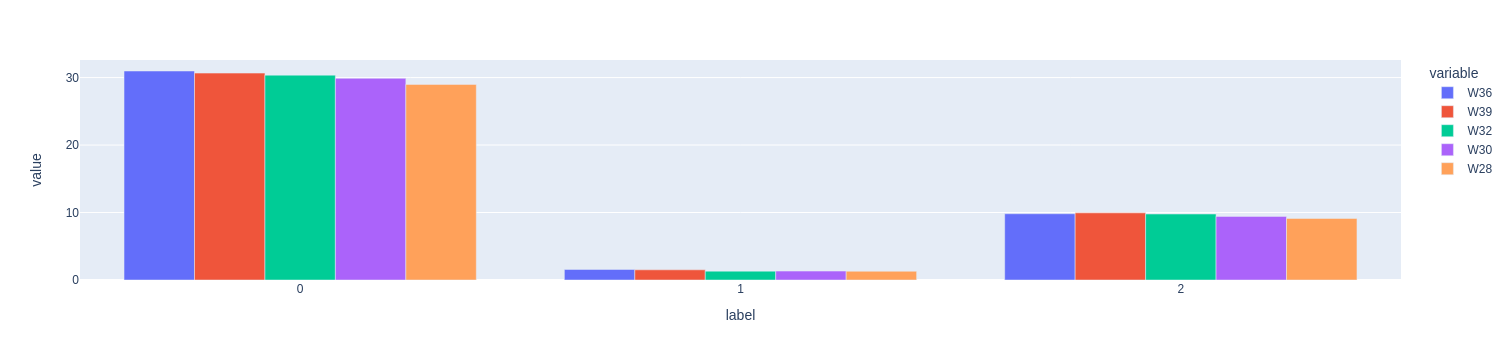

In [17]:
px.bar(xgbm,barmode='group')

In [18]:
pca_df = pd.DataFrame()
pca = make_pipeline(StandardScaler(),PCA(n_components=2,random_state=42))
pca_df[['pca1','pca2']] = pca.fit_transform(X.iloc[:,:-1])
pca_df['label'] = X['label']

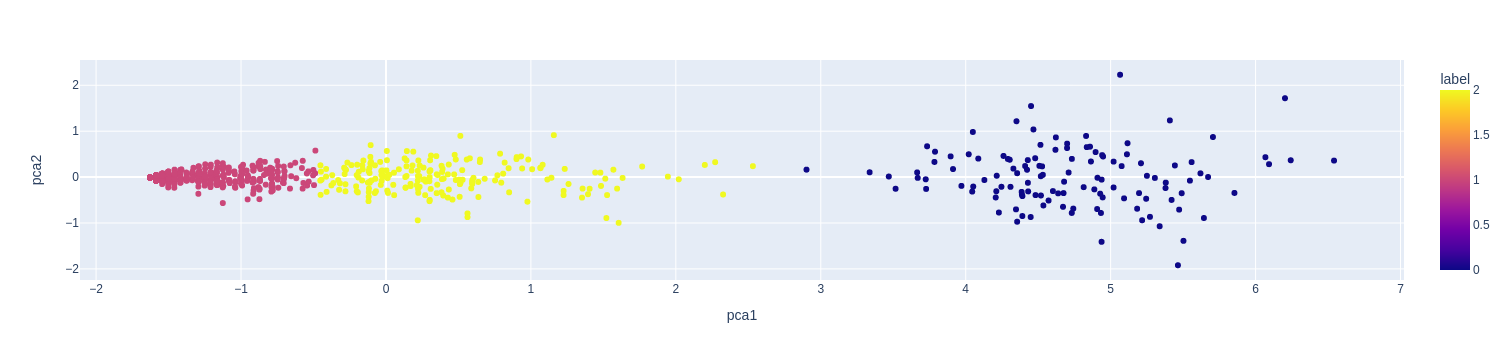

In [19]:
px.scatter(pca_df,x = 'pca1',y='pca2',color='label')

In [20]:
pca_df

pca1      pca2  label
0    0.505603 -0.056574      2
1   -0.828037  0.163694      1
2   -0.120335 -0.524078      2
3   -0.376484 -0.180693      2
4   -0.266415  0.315194      2
..        ...       ...    ...
806 -1.457149  0.072631      1
807 -0.999690 -0.052704      1
808 -1.628403 -0.007294      1
809 -1.542655  0.031184      1
810 -1.545752  0.025986      1

[811 rows x 3 columns]

In [21]:
run_simulation()

Dash app running on http://0.0.0.0:8050/
